In [186]:
from prediction_f import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import streamlit as st
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [187]:
symbol = 'F'

In [188]:
data = yf.download(symbol, start='2023-01-01', end='2025-01-01')
data['hi',symbol] = data['Close'].rolling(window=10).mean()
data['SMA10'] = data['Close'].rolling(window=10, min_periods=1).mean()
data['SMA50'] = data['Close'].rolling(window=50, min_periods=1).mean()

delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
data['RSI'] = 100 - (100 / (1 + avg_gain / avg_loss))

data['Price_Change'] = data['Close'].diff()
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data['EMA10',symbol] = data['Close'].ewm(span=10, adjust=False).mean()
data['BB_upper',symbol] = data['Close'].rolling(20).mean() + 2 * data['Close'].rolling(20).std()
data['BB_lower',symbol] = data['Close'].rolling(20).mean() - 2 * data['Close'].rolling(20).std()
data['MACD',symbol] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()




data.fillna(method='ffill', inplace=True)


print(data['Target'])



[*********************100%***********************]  1 of 1 completed

Date
2023-01-03    1
2023-01-04    1
2023-01-05    1
2023-01-06    1
2023-01-09    1
             ..
2024-12-24    1
2024-12-26    0
2024-12-27    0
2024-12-30    1
2024-12-31    0
Name: Target, Length: 502, dtype: int64


In [194]:
X = data[['SMA10', 'SMA50', 'RSI', 'Price_Change','EMA10','BB_upper','BB_lower','MACD']]
y = data['Target']

# Avoid warnings and handle missing values
X = X.copy()
X.fillna(method='ffill', inplace=True)
X.fillna(0, inplace=True)
X = X.iloc[:-1]
y = y.iloc[:-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data if necessary
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 3-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=1,  # Show progress
    n_jobs=-1  # Use all CPU cores for faster computation
)

grid_search.fit(X_train, y_train.values.ravel())

# Display best hyperparameters and cross-validated accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate the best model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.58
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.54      0.55        50
           1       0.56      0.57      0.56        51

    accuracy                           0.55       101
   macro avg       0.55      0.55      0.55       101
weighted avg       0.55      0.55      0.55       101

Confusion Matrix:
[[27 23]
 [22 29]]


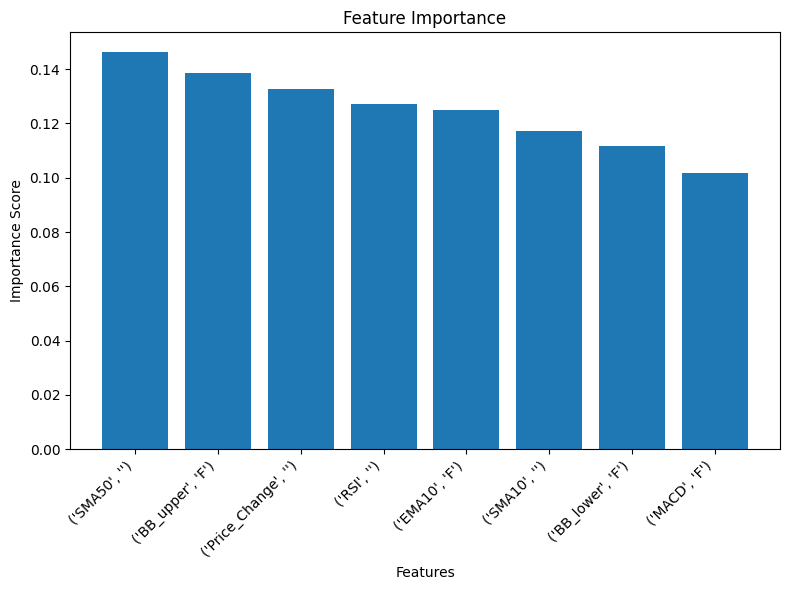

In [195]:
importance = grid_search.best_estimator_.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]  # Indices of features sorted by importance
sorted_features = features[indices]    # Correctly order the feature names

# Plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(features)), importance[indices], align="center")
plt.xticks(range(len(features)), sorted_features, rotation=45, ha="right")  # Correct tick labels
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

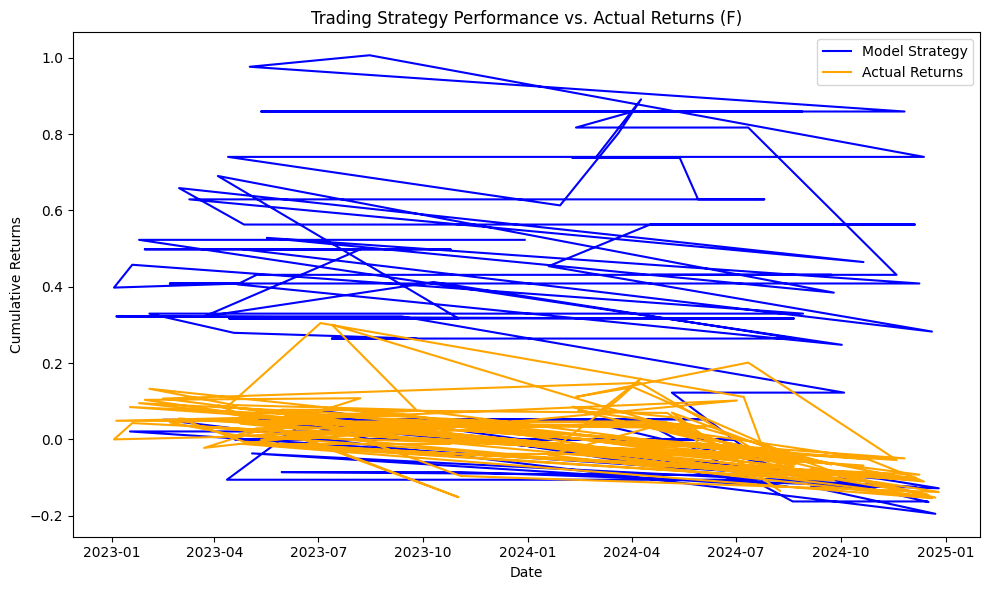

Performance Metrics (F):
- Sharpe Ratio: 0.09
- Max Drawdown: 75.87%


In [202]:
# test_data = X_test.copy()
# test_data['Predicted'] = y_pred
# test_data['Actual'] = y_test.values  # Align target values with test data indices

# # Map the 'Close' prices from the original dataset to the test data
# test_data['Close'] = data.loc[test_data.index, 'Close']

# # Calculate cumulative returns based on predictions
# # Replace 0 with -1 for downward movement
# test_data['Predicted_Returns'] = test_data['Predicted'].replace({1: 0.01, 0: -0.01})
# test_data['Cumulative_Returns'] = np.cumprod(1 + test_data['Predicted_Returns']) - 1

# # Normalize the Close price for comparison
# test_data['Normalized_Close'] = test_data['Close'] / test_data['Close'].iloc[0]

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(test_data.index, test_data['Cumulative_Returns'], label='Predicted Returns')
# plt.plot(test_data.index, test_data['Normalized_Close'], label='Actual Close Price')
# plt.legend()
# plt.title("Predicted Returns vs Actual Close Price")
# plt.xlabel("Date")
# plt.ylabel("Cumulative Returns / Normalized Price")
# plt.tight_layout()
# plt.show()

test_data = X_test.copy()
test_data['Signal'] = y_pred  # Add model's buy/sell signals


test_data['Close'] = data['Close'].reindex(test_data.index)
# Align indices and calculate daily returns
test_data['Close'] = data.loc[test_data.index, 'Close']
test_data['Signal'] = test_data['Signal'].shift(1)  # Shift signal to align with future returns
test_data['Daily_Returns'] = test_data['Close'].pct_change()

# Apply strategy: Strategy returns are daily returns * signals
test_data['Strategy_Returns'] = test_data['Signal'] * test_data['Daily_Returns']

# Replace invalid values
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.fillna(0, inplace=True)

# Calculate cumulative returns
test_data['Cumulative_Strategy'] = (1 + test_data['Strategy_Returns']).cumprod() - 1
test_data['Normalized_Close'] = data['Close'] / data['Close'].iloc[0]
test_data['Cumulative_Actual'] = test_data['Normalized_Close'] - 1

# Plot strategy vs. actual performance
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Cumulative_Strategy'], label='Model Strategy', color='blue')
plt.plot(test_data.index, test_data['Cumulative_Actual'], label='Actual Returns', color='orange')
plt.legend()
plt.title(f"Trading Strategy Performance vs. Actual Returns ({symbol})")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.tight_layout()
plt.show()

# Calculate performance metrics
mean_return = test_data['Strategy_Returns'].mean()
std_dev = test_data['Strategy_Returns'].std()
sharpe_ratio = mean_return / std_dev if std_dev != 0 else 0  # Avoid division by zero

rolling_max = test_data['Cumulative_Strategy'].cummax()
drawdown = rolling_max - test_data['Cumulative_Strategy']
max_drawdown = drawdown.max()

print(f"Performance Metrics ({symbol}):")
print(f"- Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"- Max Drawdown: {max_drawdown:.2%}")


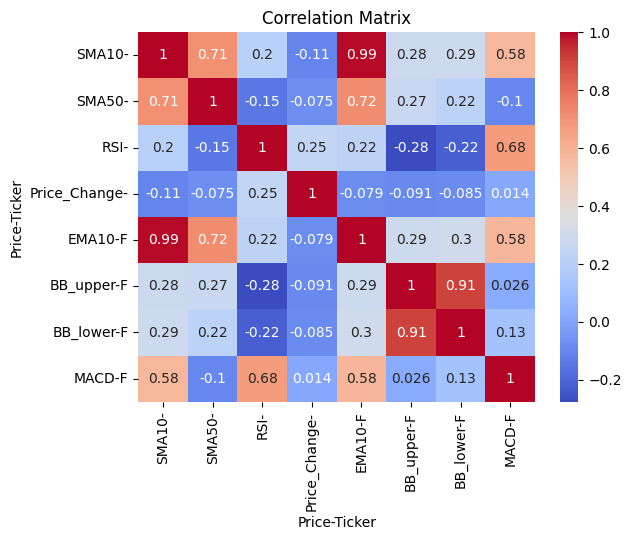

False
DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [203]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
print(test_data.index.equals(data.index))  # Should return True
print(test_data.index.difference(data.index))

In [193]:
st.title('Financial Instrument Prediction')
user_input = st.text_input('Enter Instrument (e.g., symbol):')
if user_input:
    # Fetch data and make predictions
    st.write('Prediction Results...')